In [ ]:
!pip install pandas
!pip install pandas pyreadstat
!pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.stats import chi2_contingency
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/FYP/fullsav.csv'

sav_data = pd.read_csv(data_path, low_memory=False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.5 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
#removes participants without malaise outcomes
sav_data = sav_data.dropna(subset=['malaise'])

#removes first sweep
all_sweeps = sav_data.iloc[:, 65:]

#seperates sweeps
sweep1 = sav_data.iloc[:, 65:469]
sweep2 = sav_data.iloc[:, 469:968]
sweep3 = sav_data.iloc[:, 968:1765]
sweep4 = sav_data.iloc[:, 1765:]

#setting variebels for plots
variables_to_keep = ["n115", "n135", "n315", "n321", "n322", "n397", "n400", "n68", "n69", "n70", "n457"]
variables_to_keep2 = ["n1444","n1449","n1687","n1230","n1476","n862","n876","n877","n878","n879","n1061"]
variables_to_keep3 = ["n2441","n2520","n2529","n2199","n2285","n2309","n2314","n2716","n2719","n2720","n2721","n2722"]
variables_to_keep31 = ["n2244","n2245","n2285","n2403","n2741","n2250","n2309","n2719","n2407","n2408","n2441","n2716"]
variables_to_keep4 = ["n5739", "n5740", "n4655", "n4862", "n4659", "n4660", "n5613", "n6134", "n6147", "n4873", "n5066", "n5470", "econstat", "jobhours", "curremp"]
variables_to_keep41 = ["n5739", "n5775", "econstat", "n5777", "edat", "famtyp", "n5774", "n4662", "n5776", "hcomp", "famhh", "psedta", "n5453", "n5740", "currentn"]
variables_to_keep42 = ["n5739", "econstat", "n4662", "n5740", "n4655","jobhours", "n4862", "curremp", "n4659", "dtenure","n4660", "n5613"]

sweep1_chosen = sav_data[variables_to_keep]
sweep2_chosen = sav_data[variables_to_keep2]
sweep3_chosen = sav_data[variables_to_keep3]
sweep31_chosen = sav_data[variables_to_keep31]
sweep4_chosen = sav_data[variables_to_keep4]
sweep41_chosen = sav_data[variables_to_keep41]
sweep42_chosen = sav_data[variables_to_keep42]

In [ ]:
#removes the variables which were identified to be directly related to depresion(such as malaise questions)
all_sweeps_columns_to_remove = list(range(1700+885, 1700+909)) + list(range(1700+1041, 1700+1134)) + list(range(1700+1434, 1700+1467)) + [1700+1468]

sweep4_columns_to_remove = list(range(885, 909)) + list(range(1041, 1134)) + list(range(1434, 1467)) + [1468]

all_sweeps_column_labels_to_remove = [all_sweeps.columns[i] for i in all_sweeps_columns_to_remove if i < len(all_sweeps.columns)]

sweep4_column_labels_to_remove = [sweep4.columns[i] for i in sweep4_columns_to_remove if i < len(sweep4.columns)]

all_sweeps = all_sweeps.drop(columns=all_sweeps_column_labels_to_remove, axis=1)

sweep4 = sweep4.drop(columns=sweep4_column_labels_to_remove, axis=1)

In [ ]:
#function to add malaise column back so chi-squared test can be applied on them
def add_malaise(df, sav_data):
  if 'malaise' not in df.columns:
    data = pd.concat([df, sav_data[['malaise']]], axis=1)
  else:
    data = df
  return data

all_sweeps = add_malaise(all_sweeps, sav_data)
sweep1 = add_malaise(sweep1, sav_data)
sweep2 = add_malaise(sweep2, sav_data)
sweep3 = add_malaise(sweep3, sav_data)
sweep4 = add_malaise(sweep4, sav_data)
sweep1_chosen = add_malaise(sweep1_chosen, sav_data)
sweep2_chosen = add_malaise(sweep2_chosen, sav_data)
sweep3_chosen = add_malaise(sweep3_chosen, sav_data)
sweep31_chosen = add_malaise(sweep31_chosen, sav_data)
sweep4_chosen = add_malaise(sweep4_chosen, sav_data)
sweep41_chosen = add_malaise(sweep41_chosen, sav_data)
sweep42_chosen = add_malaise(sweep42_chosen, sav_data)

column_to_move = all_sweeps.columns[-4]
columns_except_one = all_sweeps.columns.drop(column_to_move)
new_column_order = list(columns_except_one) + [column_to_move]
all_sweeps = all_sweeps[new_column_order]

#calculates the percentage of missing values for each column and removes those which have more than 26%
def clean_data(df, missing_threshold=26):
  missing_percentage = df.isnull().mean() * 100
  columns_to_drop = missing_percentage[missing_percentage > missing_threshold].index
  df_cleaned = df.drop(columns=columns_to_drop)
  return df_cleaned

cleaned_all_sweeps = clean_data(all_sweeps)
cleaned_sweep1 = clean_data(sweep1)
cleaned_sweep2 = clean_data(sweep2)
cleaned_sweep3 = clean_data(sweep3)
cleaned_sweep4 = clean_data(sweep4)
sweep1_chosen = clean_data(sweep1_chosen)
sweep2_chosen = clean_data(sweep2_chosen)
sweep3_chosen = clean_data(sweep3_chosen)
sweep31_chosen = clean_data(sweep31_chosen)
sweep4_chosen = clean_data(sweep4_chosen)
sweep41_chosen = clean_data(sweep41_chosen)
sweep42_chosen = clean_data(sweep42_chosen)

In [ ]:
def perform_chi2_tests(df, top_n=30):
  chi2_results = []
  for column in df.columns:
    if column != 'malaise' and df[column].dtype == 'O': #checks if the data has column malaise
      contingency_table = pd.crosstab(df[column], df['malaise'], margins=False)
      #creates a contingency table between the current column and the malaise column
      if not contingency_table.empty and all(contingency_table.sum() > 0) and contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
      #check if the contingency table is empty, all entries are positive and the table is at least 2x2 to perform a chi-square test
        try:
          #performs the chi-square test
          chi2, p, dof, expected = chi2_contingency(contingency_table)
          #calculates the total number of observations
          n = contingency_table.sum().sum()
          #calculates phi value
          phi2 = chi2 / n
          #sets the number of rows and columns to calculate crammer's v
          r, k = contingency_table.shape
          #calculates cramer's v
          cramer_v = np.sqrt(phi2 / min(k - 1, r - 1))
          chi2_results.append((column, chi2, p, cramer_v))
        except ValueError as e: #skips the column if there was an error
          print(f"Skipping {column} due to error: {e}")
  chi2_results.sort(key=lambda x: x[1], reverse=True)
    #sorts the results by their chi-square statistic and cramer_v values so it will return the best results
  return chi2_results[:top_n]


cleaned_all_sweeps_results = perform_chi2_tests(cleaned_all_sweeps, top_n=200)
cleaned_sweep1_results = perform_chi2_tests(cleaned_sweep1)
cleaned_sweep2_results = perform_chi2_tests(cleaned_sweep2)
cleaned_sweep3_results = perform_chi2_tests(cleaned_sweep3, top_n=75)
cleaned_sweep4_results = perform_chi2_tests(cleaned_sweep4, top_n=100)
sweep1_chosen_results = perform_chi2_tests(sweep1_chosen, top_n=15)
sweep2_chosen_results = perform_chi2_tests(sweep2_chosen, top_n=15)
sweep3_chosen_results = perform_chi2_tests(sweep3_chosen, top_n=15)
sweep31_chosen_results = perform_chi2_tests(sweep31_chosen, top_n=15)
sweep4_chosen_results = perform_chi2_tests(sweep4_chosen, top_n=20)
sweep41_chosen_results = perform_chi2_tests(sweep41_chosen, top_n=20)
sweep42_chosen_results = perform_chi2_tests(sweep42_chosen, top_n=20)

In [ ]:
cleaned_sweep1_results

[('n70', 232.8521433236141, 3.2104363199530817e-49, 0.14458941917303017),
 ('n67', 219.66682629605498, 2.2111868802541426e-46, 0.14045497508663687),
 ('n68', 172.6933553210516, 2.7628719168614387e-36, 0.12461933235456465),
 ('n81', 154.9778893882172, 6.849145397327594e-31, 0.11816078883012124),
 ('n69', 154.86381464965265, 1.8460467794297657e-32, 0.11795799831527157),
 ('n457', 149.40604065363084, 7.482608298172817e-26, 0.11627418094967656),
 ('n43', 133.56077002191603, 6.74141901652794e-28, 0.109589144522808),
 ('n65', 125.62187166845234, 3.360874363456402e-26, 0.10618680231868072),
 ('n44', 121.82696263417239, 2.174685280864408e-25, 0.10479660219415877),
 ('n38', 101.51658899992599, 7.33462530529994e-22, 0.09554679302973347),
 ('n390', 90.97806458335039, 3.4260555846820535e-15, 0.09269608250657405),
 ('n607', 87.85807853432837, 6.317611944861474e-19, 0.09141711644201041),
 ('n304', 84.39501734176228, 4.71905277410598e-19, 0.08799239820260658),
 ('n37', 84.1561980734786, 3.93793449032

In [ ]:
cleaned_sweep2_results

[('n876', 284.34066688175346, 2.582627271601425e-60, 0.16287806921215991),
 ('n877', 263.5026494693559, 8.019837118272142e-56, 0.15694272766581446),
 ('n878', 193.15542814136853, 1.1121985999770393e-40, 0.13426331659832527),
 ('n879', 161.72484832771968, 6.237061026556219e-34, 0.12284338098382339),
 ('n851', 154.55956097456166, 2.1451979378774349e-32, 0.12346076402607245),
 ('n958', 152.11358030496143, 2.473371415827099e-22, 0.12056885282167233),
 ('n852', 142.4506605731338, 8.431825719275682e-30, 0.11630474337452978),
 ('n1476', 131.2984850713249, 2.0544304513994754e-27, 0.11541958546688291),
 ('n862', 111.03538254704218, 6.569065446535302e-24, 0.10241527883775216),
 ('n1451', 109.63930851502978, 8.687879692568981e-23, 0.10172616292854632),
 ('n1136', 108.9022577597701, 2.249962055770329e-24, 0.10131674227875122),
 ('n1152', 105.2743089630501, 4.079368374672386e-21, 0.09962421566303062),
 ('n946', 104.72271846715054, 1.8186562519467415e-23, 0.1011870871219733),
 ('n947', 98.5988908134

In [ ]:
cleaned_sweep3_results

[('n2244', 300.7866579884792, 6.784816420901374e-63, 0.17720223594496162),
 ('n2221', 288.4408593077759, 1.3881154241049432e-29, 0.1762343932250994),
 ('n2218', 270.174534193682, 1.6142479977073324e-26, 0.16900501540305304),
 ('n2245', 270.14620785091574, 2.6033186127987815e-56, 0.16746291924237686),
 ('n2285', 263.3379775897997, 4.002012540812233e-53, 0.16146357438096068),
 ('n2214', 239.33704612128392, 3.1285383403182892e-47, 0.15954927678008135),
 ('n2208', 224.60629056806502, 4.092987564657479e-44, 0.15367310517433866),
 ('n2217', 224.48269178729186, 4.346791812081089e-44, 0.15530540616192134),
 ('n2211', 218.88485539840102, 6.624019377618493e-43, 0.15213570886985786),
 ('n2215', 212.4822433051952, 4.356533083123625e-18, 0.14916249381380503),
 ('n2403', 206.6064902863116, 1.3676364645221572e-45, 0.1487061074705698),
 ('n2525', 169.77833258631728, 1.3586372123543842e-37, 0.13486025324114356),
 ('n2741', 163.33083196008988, 3.4131901019405385e-36, 0.13084583402207292),
 ('n2250', 161

In [ ]:
cleaned_sweep4_results

[('n5739', 1249.149519079992, 1.5893623663309734e-270, 0.31646213330368617),
 ('n4135', 602.6594917583601, 0.6734910996146375, 0.21975871559745921),
 ('n5762', 536.5426392367606, 1.065561409286598e-118, 0.20737883842278113),
 ('n5870', 477.68273213562605, 3.2728705674364527e-103, 0.19567353368270102),
 ('n4223pw', 425.84711733272104, 0.9999999999906442, 0.18967322653927945),
 ('newghsq', 416.1328360192235, 5.03995791932625e-80, 0.1826106493397406),
 ('n5775', 389.97162201054346, 8.395666601196877e-87, 0.1768694971683961),
 ('econstat', 371.9589175277125, 3.236391896985351e-72, 0.17285432642640872),
 ('n5777', 349.0375561483982, 6.866354181372767e-78, 0.16748407886093442),
 ('edat', 292.38216344256153, 3.522001312455206e-56, 0.15309907535744804),
 ('redat', 289.9178852661319, 8.593498057203354e-59, 0.15245252936769735),
 ('n5876', 281.8328015679895, 2.993653235527639e-63, 0.1502816229505442),
 ('famtyp', 279.8495851121322, 4.867911980407416e-55, 0.1497579350211191),
 ('econst5', 279.564

In [ ]:
cleaned_all_sweeps_results

[('n5739', 1249.149519079992, 1.5893623663309734e-270, 0.31646213330368617),
 ('n4135', 602.6594917583601, 0.6734910996146375, 0.21975871559745921),
 ('n5762', 536.5426392367606, 1.065561409286598e-118, 0.20737883842278113),
 ('n5870', 477.68273213562605, 3.2728705674364527e-103, 0.19567353368270102),
 ('n4223pw', 425.84711733272104, 0.9999999999906442, 0.18967322653927945),
 ('newghsq', 416.1328360192235, 5.03995791932625e-80, 0.1826106493397406),
 ('n5775', 389.97162201054346, 8.395666601196877e-87, 0.1768694971683961),
 ('econstat', 371.9589175277125, 3.236391896985351e-72, 0.17285432642640872),
 ('n5777', 349.0375561483982, 6.866354181372767e-78, 0.16748407886093442),
 ('n2244', 300.7866579884792, 6.784816420901374e-63, 0.17720223594496162),
 ('edat', 292.38216344256153, 3.522001312455206e-56, 0.15309907535744804),
 ('redat', 289.9178852661319, 8.593498057203354e-59, 0.15245252936769735),
 ('n2221', 288.4408593077759, 1.3881154241049432e-29, 0.1762343932250994),
 ('n876', 284.34066

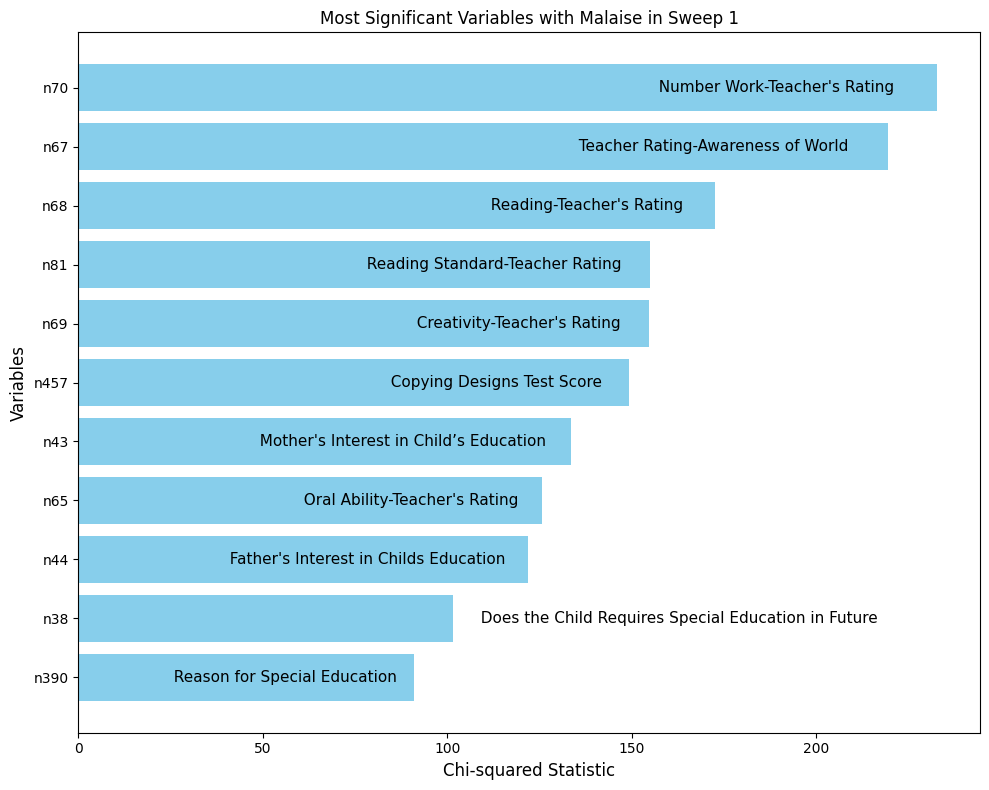

In [ ]:
top_n = 11
top_15_cleaned_sweep1_results = cleaned_sweep1_results[:top_n]

#label names for the specific sweep and variable
label_names = [
  "Number Work-Teacher's Rating",
  "Teacher Rating-Awareness of World",
  "Reading-Teacher's Rating",
  "Reading Standard-Teacher Rating",
  "Creativity-Teacher's Rating",
  "Copying Designs Test Score",
  "Mother's Interest in Child’s Education",
  "Oral Ability-Teacher's Rating",
  "Father's Interest in Childs Education",
  "Does the Child Requires Special Education in Future",
  "Reason for Special Education"
]


#extracts the column names and chi-squared statistics for the adjusted variables
column_names_adjusted = [result[0] for result in top_15_cleaned_sweep1_results]
chi_squared_statistics_adjusted = [result[1] for result in top_15_cleaned_sweep1_results]

#creates a plot fot the adjusted variables
plt.figure(figsize=(10, 8))
bars = plt.barh(column_names_adjusted, chi_squared_statistics_adjusted, color='skyblue')

#adds label names on the bars
#if conditions were addedd so if the variable name did not fit in the bar they will be on the side of the bar
for i, (bar, label_name) in enumerate(zip(bars, label_names)):
  if i == 9:
    plt.text(bar.get_width() + (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2,
             '  ' + label_name, va='center', ha='left', fontsize=11, color='black')
  else:
    plt.text(bar.get_width() - (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2,
             '  ' + label_name, va='center', ha='right', fontsize=11, color='black')

plt.xlabel('Chi-squared Statistic', fontsize=12)
plt.ylabel('Variables',fontsize=12)
plt.title('Most Significant Variables with Malaise in Sweep 1', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


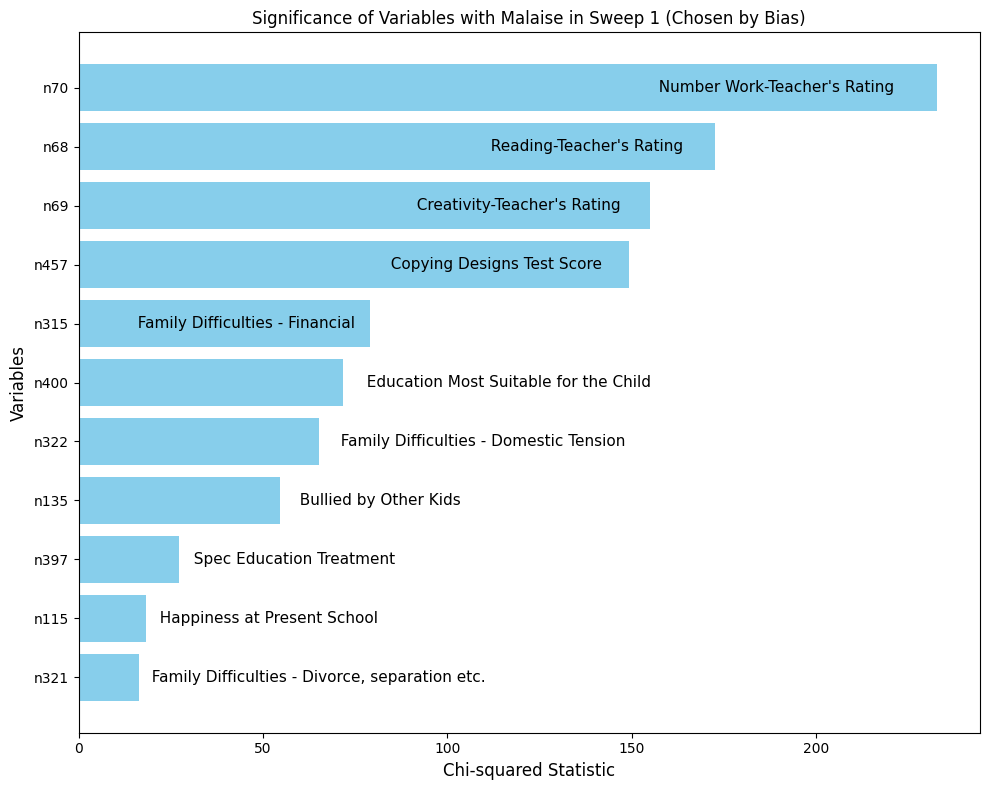

In [ ]:
label_names1 = [
  "Number Work-Teacher's Rating",
  "Reading-Teacher's Rating",
  "Creativity-Teacher's Rating",
  "Copying Designs Test Score",
  "Family Difficulties - Financial",
  "Education Most Suitable for the Child",
  "Family Difficulties - Domestic Tension",
  "Bullied by Other Kids",
  "Spec Education Treatment",
  "Happiness at Present School",
  "Family Difficulties - Divorce, separation etc."
]

column_names_adjusted = [result[0] for result in sweep1_chosen_results]
chi_squared_statistics_adjusted = [result[1] for result in sweep1_chosen_results]

plt.figure(figsize=(10, 8))
bars = plt.barh(column_names_adjusted, chi_squared_statistics_adjusted, color='skyblue')

for i, (bar, label_name) in enumerate(zip(bars, label_names1)):
  if i < 5:
    plt.text(bar.get_width() - (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2,
             '  ' + label_name, va='center', ha='right', fontsize=11, color='black')
  else:
    plt.text(bar.get_width() + (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2,
             '  ' + label_name, va='center', ha='left', fontsize=11, color='black')

plt.xlabel('Chi-squared Statistic', fontsize =12)
plt.ylabel('Variables', fontsize = 12)
plt.title('Significance of Variables with Malaise in Sweep 1 (Chosen by Bias)', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

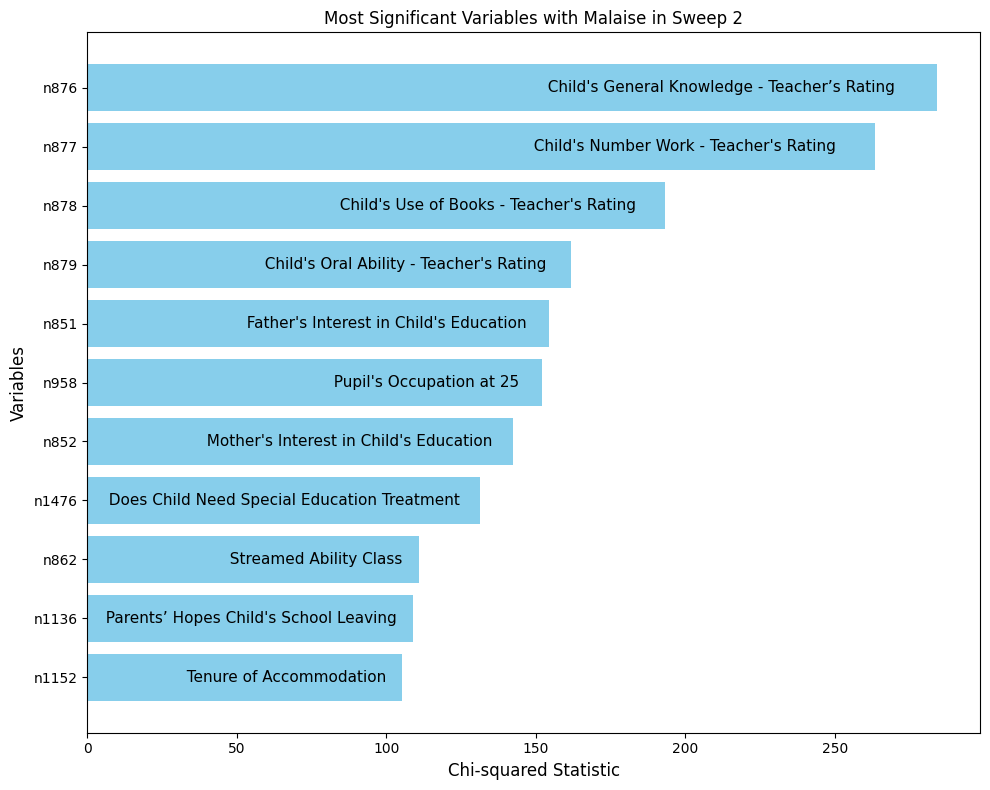

In [ ]:
top_n = 12
top_15_cleaned_sweep2_results = cleaned_sweep2_results[:top_n]

label_names22 = [
  "Child's General Knowledge - Teacher’s Rating",
  "Child's Number Work - Teacher's Rating",
  "Child's Use of Books - Teacher's Rating",
  "Child's Oral Ability - Teacher's Rating",
  "Father's Interest in Child's Education",
  "Pupil's Occupation at 25",
  "Mother's Interest in Child's Education",
  "Does Child Need Special Education Treatment",
  "Streamed Ability Class",
  "Parents’ Hopes Child's School Leaving",
  "Tenure of Accommodation"
]

variables_to_remove = ["n1451"]

#removes the certain variable
filtered_top_15_cleaned_sweep2_results = [
    result for result in top_15_cleaned_sweep2_results if result[0] not in variables_to_remove
]

filtered_top_15_cleaned_sweep2_results

column_names_adjusted = [result[0] for result in filtered_top_15_cleaned_sweep2_results]
chi_squared_statistics_adjusted = [result[1] for result in filtered_top_15_cleaned_sweep2_results]

plt.figure(figsize=(10, 8))
bars = plt.barh(column_names_adjusted, chi_squared_statistics_adjusted, color='skyblue')

for bar, label_name in zip(bars, label_names22):
  plt.text(bar.get_width() - (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2, '  ' + label_name,
           va='center', ha='right', fontsize=11, color='black')

plt.xlabel('Chi-squared Statistic', fontsize =12)
plt.ylabel('Variables', fontsize =12)
plt.title('Most Significant Variables with Malaise in Sweep 2', fontsize =12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

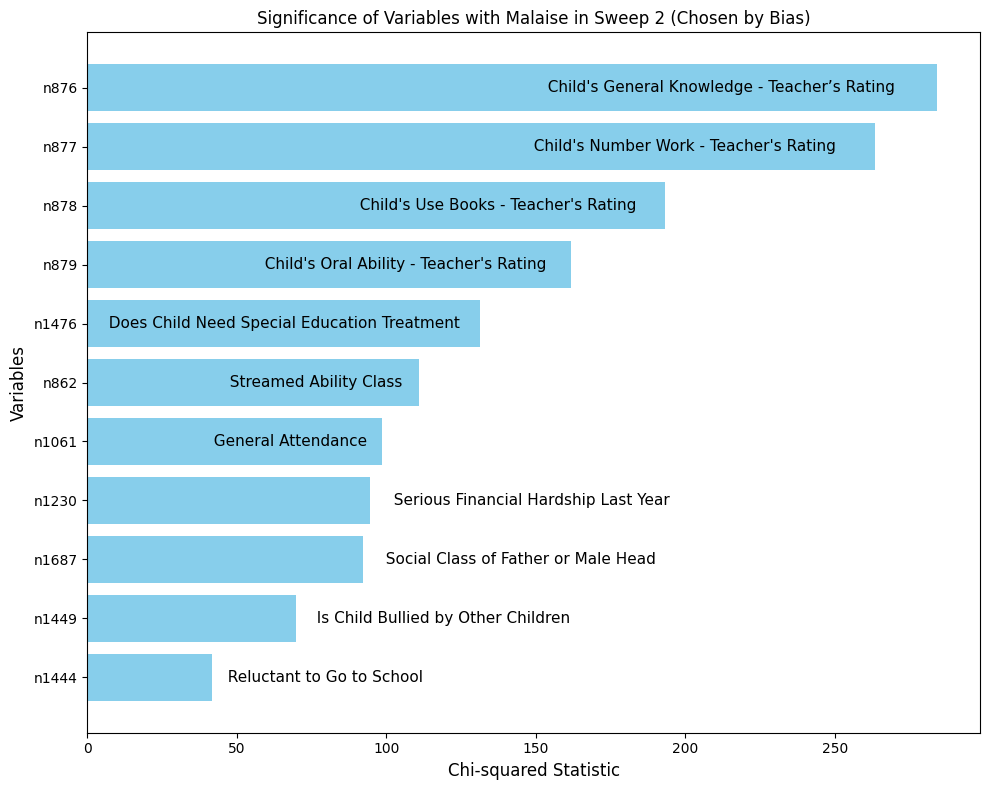

In [ ]:
label_names2 = [
  "Child's General Knowledge - Teacher’s Rating",
  "Child's Number Work - Teacher's Rating",
  "Child's Use Books - Teacher's Rating",
  "Child's Oral Ability - Teacher's Rating",
  "Does Child Need Special Education Treatment",
  "Streamed Ability Class",
  "General Attendance",
  "Serious Financial Hardship Last Year",
  "Social Class of Father or Male Head",
  "Is Child Bullied by Other Children",
  "Reluctant to Go to School"
]

column_names_adjusted = [result[0] for result in sweep2_chosen_results]
chi_squared_statistics_adjusted = [result[1] for result in sweep2_chosen_results]

plt.figure(figsize=(10, 8))
bars = plt.barh(column_names_adjusted, chi_squared_statistics_adjusted, color='skyblue')

for i, (bar, label_name) in enumerate(zip(bars, label_names2)):
  if i < len(bars) - 4:
    plt.text(bar.get_width() - (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2,
             '  ' + label_name, va='center', ha='right', fontsize=11, color='black')
  else:
    plt.text(bar.get_width() + (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2,
             '  ' + label_name, va='center', ha='left', fontsize=11, color='black')

plt.xlabel('Chi-squared Statistic', fontsize =12)
plt.ylabel('Variables', fontsize =12)
plt.title('Significance of Variables with Malaise in Sweep 2 (Chosen by Bias)', fontsize =12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

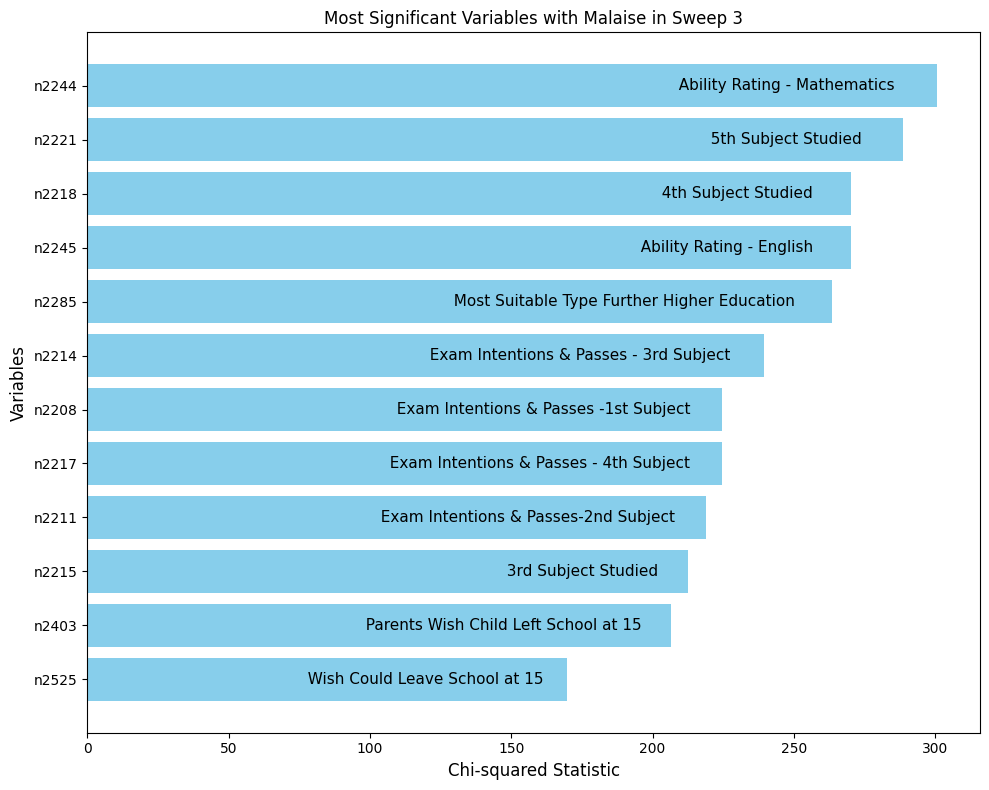

In [ ]:
top_n = 12
top_15_cleaned_sweep3_results = cleaned_sweep3_results[:top_n]


label_names32 = [
"Ability Rating - Mathematics",
"5th Subject Studied",
"4th Subject Studied",
"Ability Rating - English",
"Most Suitable Type Further Higher Education",
"Exam Intentions & Passes - 3rd Subject",
"Exam Intentions & Passes -1st Subject",
"Exam Intentions & Passes - 4th Subject",
"Exam Intentions & Passes-2nd Subject",
"3rd Subject Studied",
"Parents Wish Child Left School at 15",
"Wish Could Leave School at 15"
]

column_names_adjusted = [result[0] for result in top_15_cleaned_sweep3_results]
chi_squared_statistics_adjusted = [result[1] for result in top_15_cleaned_sweep3_results]

plt.figure(figsize=(10, 8))
bars = plt.barh(column_names_adjusted, chi_squared_statistics_adjusted, color='skyblue')

for bar, label_name in zip(bars, label_names32):
  plt.text(bar.get_width() - (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2, '  ' + label_name,
           va='center', ha='right', fontsize=11, color='black')

plt.xlabel('Chi-squared Statistic', fontsize =12)
plt.ylabel('Variables', fontsize =12)
plt.title('Most Significant Variables with Malaise in Sweep 3', fontsize =12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

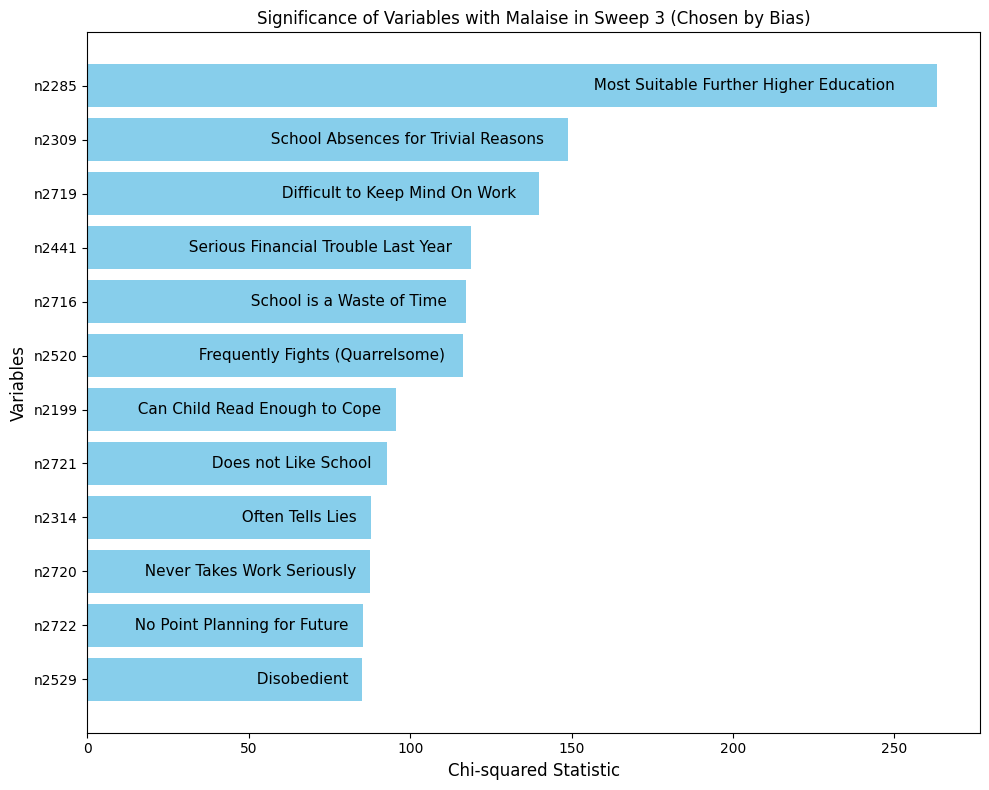

In [ ]:
label_names3 = [
  "Most Suitable Further Higher Education",
  "School Absences for Trivial Reasons",
  "Difficult to Keep Mind On Work",
  "Serious Financial Trouble Last Year",
  "School is a Waste of Time",
  "Frequently Fights (Quarrelsome)",
  "Can Child Read Enough to Cope",
  "Does not Like School",
  "Often Tells Lies",
  "Never Takes Work Seriously",
  "No Point Planning for Future",
  "Disobedient"
]

column_names_adjusted = [result[0] for result in sweep3_chosen_results]
chi_squared_statistics_adjusted = [result[1] for result in sweep3_chosen_results]

plt.figure(figsize=(10, 8))
bars = plt.barh(column_names_adjusted, chi_squared_statistics_adjusted, color='skyblue')

for bar, label_name in zip(bars, label_names3):
  plt.text(bar.get_width() - (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2, '  ' + label_name,
           va='center', ha='right', fontsize=11, color='black')

plt.xlabel('Chi-squared Statistic', fontsize =12)
plt.ylabel('Variables', fontsize =12)
plt.title('Significance of Variables with Malaise in Sweep 3 (Chosen by Bias)', fontsize =12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

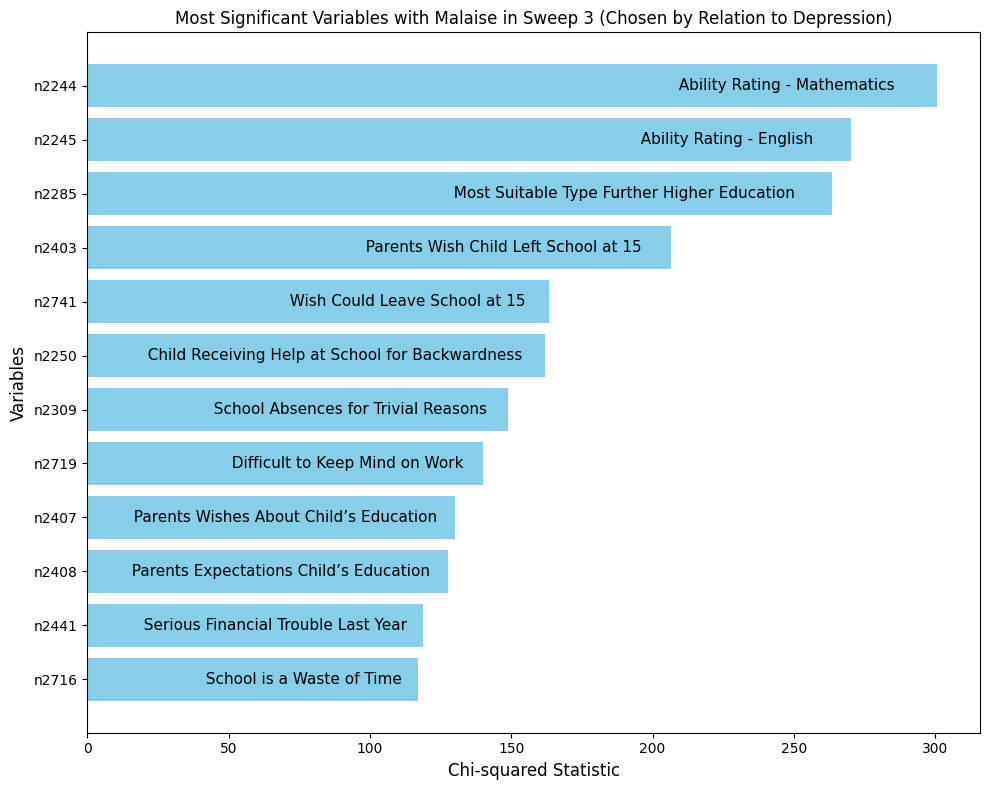

In [ ]:
label_names31 = [
  "Ability Rating - Mathematics",
  "Ability Rating - English",
  "Most Suitable Type Further Higher Education",
  "Parents Wish Child Left School at 15",
  "Wish Could Leave School at 15",
  "Child Receiving Help at School for Backwardness",
  "School Absences for Trivial Reasons",
  "Difficult to Keep Mind on Work",
  "Parents Wishes About Child’s Education",
  "Parents Expectations Child’s Education",
  "Serious Financial Trouble Last Year",
  "School is a Waste of Time"
]

column_names_adjusted = [result[0] for result in sweep31_chosen_results]
chi_squared_statistics_adjusted = [result[1] for result in sweep31_chosen_results]

plt.figure(figsize=(10, 8))
bars = plt.barh(column_names_adjusted, chi_squared_statistics_adjusted, color='skyblue')

for bar, label_name in zip(bars, label_names31):
  plt.text(bar.get_width() - (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2, '  ' + label_name,
           va='center', ha='right', fontsize=11, color='black')

plt.xlabel('Chi-squared Statistic', fontsize =12)
plt.ylabel('Variables', fontsize =12)
plt.title('Most Significant Variables with Malaise in Sweep 3 (Chosen by Relation to Depression)', fontsize =12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

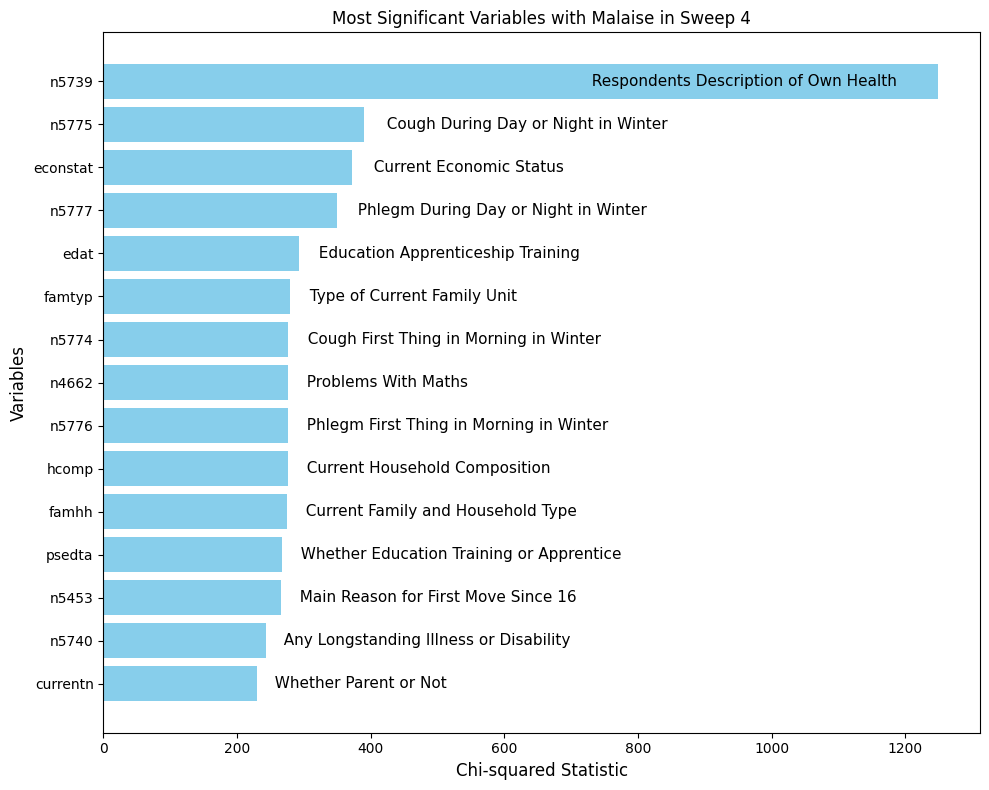

In [ ]:
label_names41 = [
  "Respondents Description of Own Health",
  "Cough During Day or Night in Winter",
  "Current Economic Status",
  "Phlegm During Day or Night in Winter",
  "Education Apprenticeship Training",
  "Type of Current Family Unit",
  "Cough First Thing in Morning in Winter",
  "Problems With Maths",
  "Phlegm First Thing in Morning in Winter",
  "Current Household Composition",
  "Current Family and Household Type",
  "Whether Education Training or Apprentice",
  "Main Reason for First Move Since 16",
  "Any Longstanding Illness or Disability",
  "Whether Parent or Not"
]

column_names_adjusted = [result[0] for result in sweep41_chosen_results]
chi_squared_statistics_adjusted = [result[1] for result in sweep41_chosen_results]

plt.figure(figsize=(10, 8))
bars = plt.barh(column_names_adjusted, chi_squared_statistics_adjusted, color='skyblue')

for i, (bar, label_name) in enumerate(zip(bars, label_names41)):
  if i == 0:
    plt.text(bar.get_width() - (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2,
             '  ' + label_name, va='center', ha='right', fontsize=11)
  else:
    plt.text(bar.get_width() + (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2,
             '  ' + label_name, va='center', ha='left', fontsize=11)

plt.xlabel('Chi-squared Statistic', fontsize =12)
plt.ylabel('Variables', fontsize =12)
plt.title('Most Significant Variables with Malaise in Sweep 4', fontsize =12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

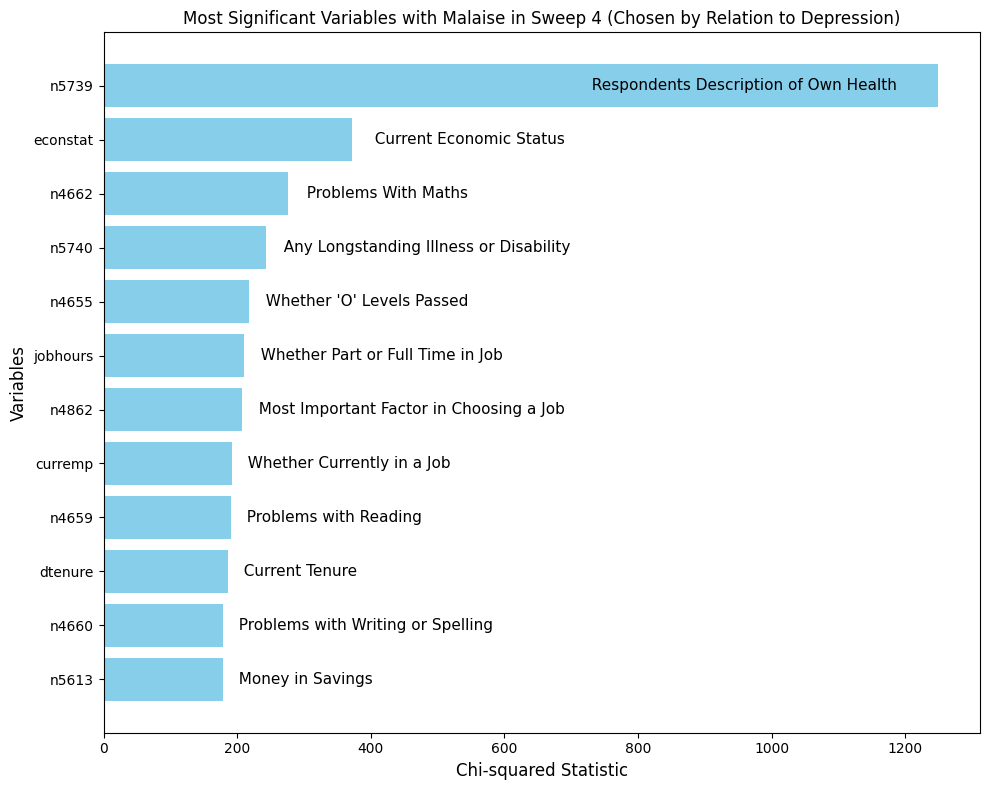

In [ ]:
label_names42 = [
  "Respondents Description of Own Health",
  "Current Economic Status",
  "Problems With Maths",
  "Any Longstanding Illness or Disability",
  "Whether 'O' Levels Passed",
  "Whether Part or Full Time in Job",
  "Most Important Factor in Choosing a Job",
  "Whether Currently in a Job",
  "Problems with Reading",
  "Current Tenure",
  "Problems with Writing or Spelling",
  "Money in Savings"
]


column_names_adjusted = [result[0] for result in sweep42_chosen_results]
chi_squared_statistics_adjusted = [result[1] for result in sweep42_chosen_results]

plt.figure(figsize=(10, 8))
bars = plt.barh(column_names_adjusted, chi_squared_statistics_adjusted, color='skyblue')

for i, (bar, label_name) in enumerate(zip(bars, label_names42)):
  if i == 0:
    plt.text(bar.get_width() - (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2,
             '  ' + label_name, va='center', ha='right', fontsize=11)
  else:
    plt.text(bar.get_width() + (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2,
             '  ' + label_name, va='center', ha='left', fontsize=11)

plt.xlabel('Chi-squared Statistic', fontsize =12)
plt.ylabel('Variables', fontsize =12)
plt.title('Most Significant Variables with Malaise in Sweep 4 (Chosen by Relation to Depression)', fontsize =12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

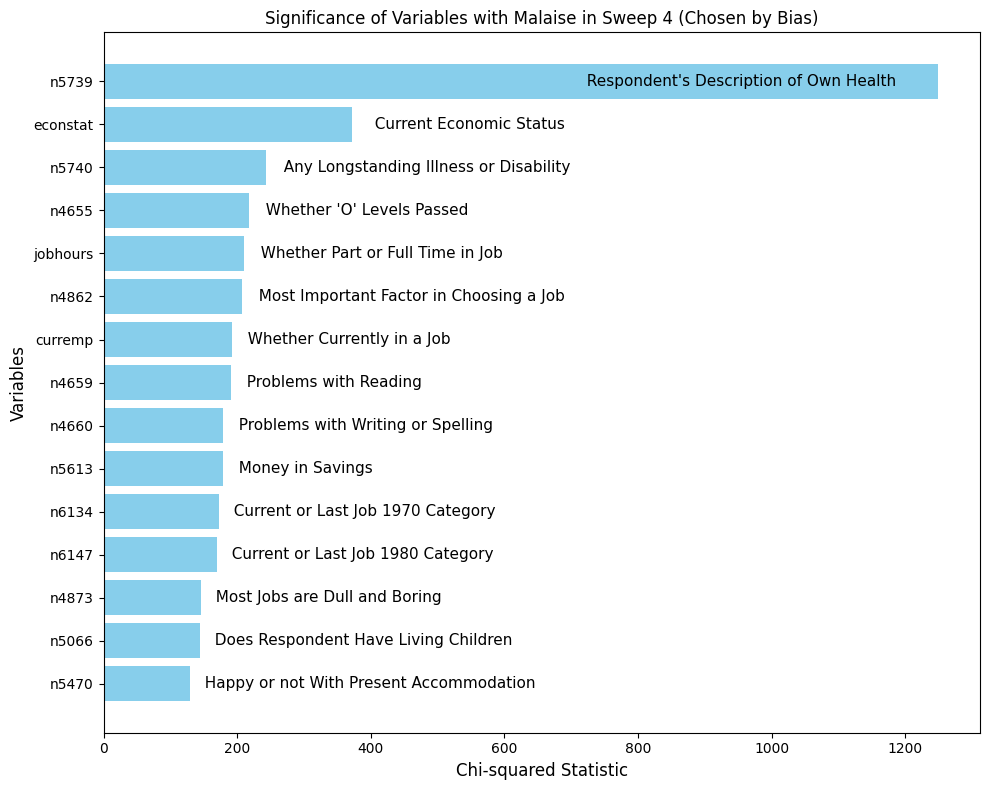

In [ ]:
label_names4 = [
  "Respondent's Description of Own Health",
  "Current Economic Status",
  "Any Longstanding Illness or Disability",
  "Whether 'O' Levels Passed",
  "Whether Part or Full Time in Job",
  "Most Important Factor in Choosing a Job",
  "Whether Currently in a Job",
  "Problems with Reading",
  "Problems with Writing or Spelling",
  "Money in Savings",
  "Current or Last Job 1970 Category",
  "Current or Last Job 1980 Category",
  "Most Jobs are Dull and Boring",
  "Does Respondent Have Living Children",
  "Happy or not With Present Accommodation"
]


column_names_adjusted = [result[0] for result in sweep4_chosen_results]
chi_squared_statistics_adjusted = [result[1] for result in sweep4_chosen_results]

plt.figure(figsize=(10, 8))
bars = plt.barh(column_names_adjusted, chi_squared_statistics_adjusted, color='skyblue')

for i, (bar, label_name) in enumerate(zip(bars, label_names4)):
  if i == 0:
    plt.text(bar.get_width() - (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2,
             '  ' + label_name, va='center', ha='right', fontsize=11)
  else:
    plt.text(bar.get_width() + (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2,
             '  ' + label_name, va='center', ha='left', fontsize=11)

plt.xlabel('Chi-squared Statistic', fontsize =12)
plt.ylabel('Variables', fontsize =12)
plt.title('Significance of Variables with Malaise in Sweep 4 (Chosen by Bias)', fontsize =12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

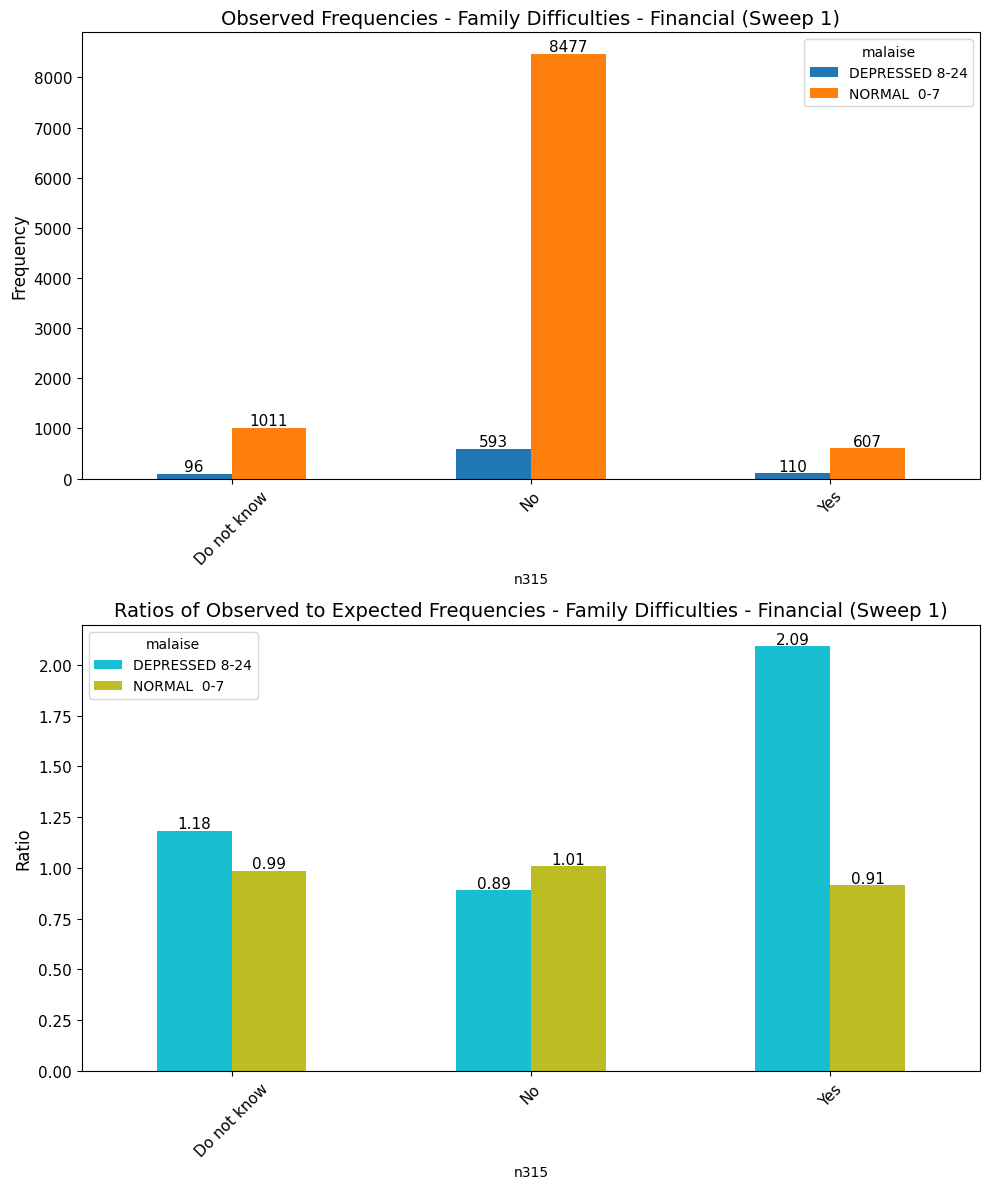

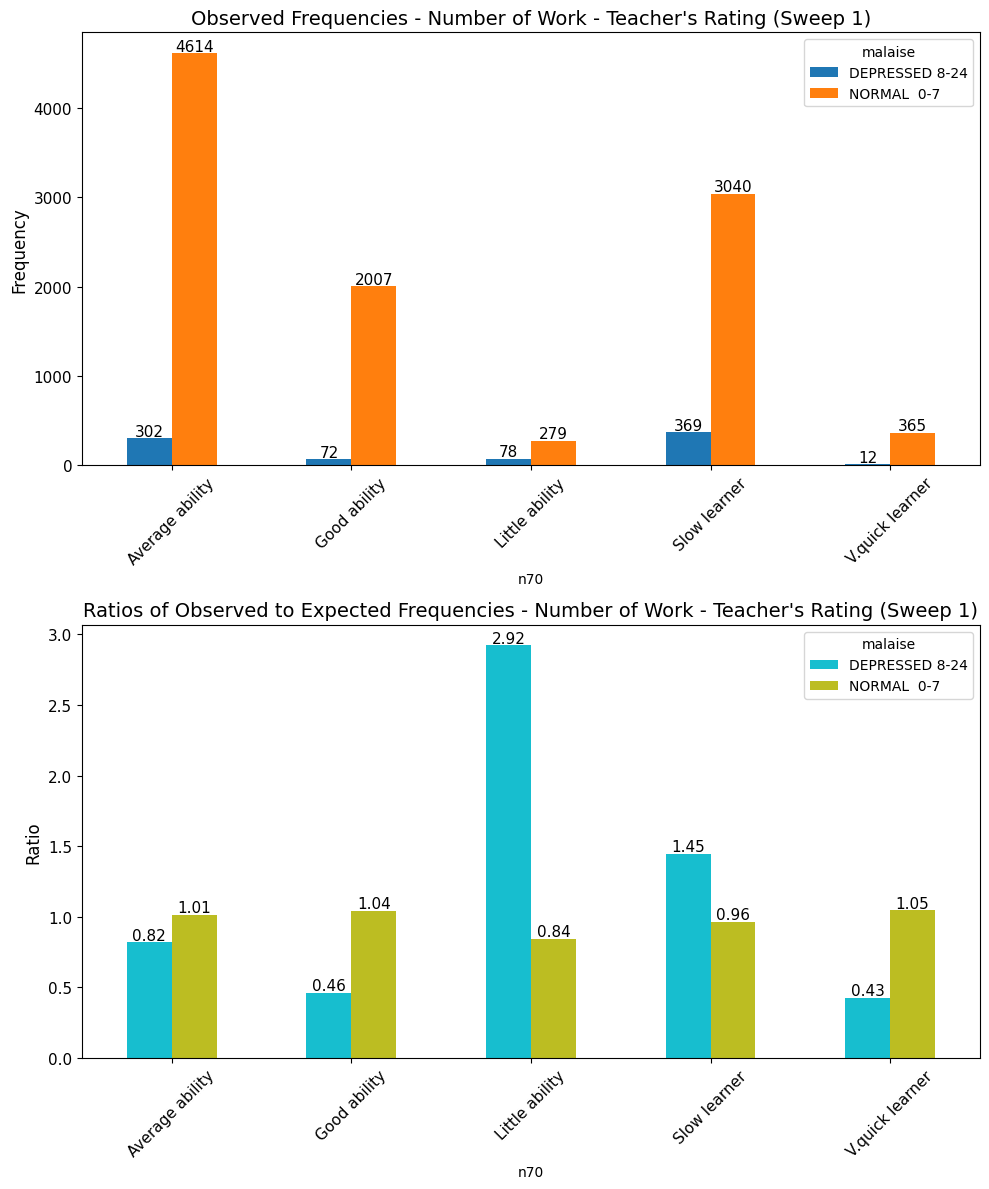

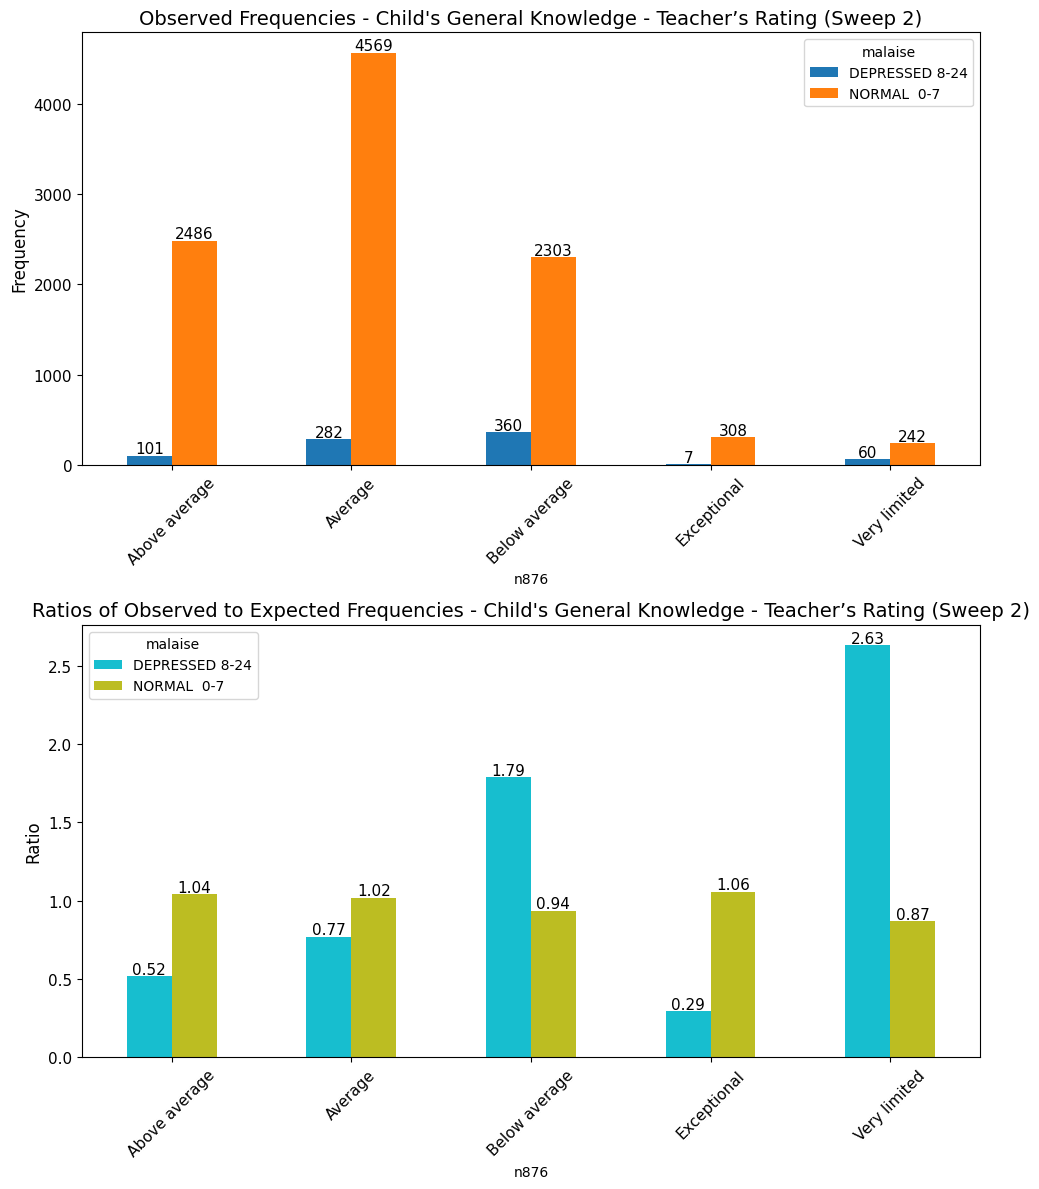

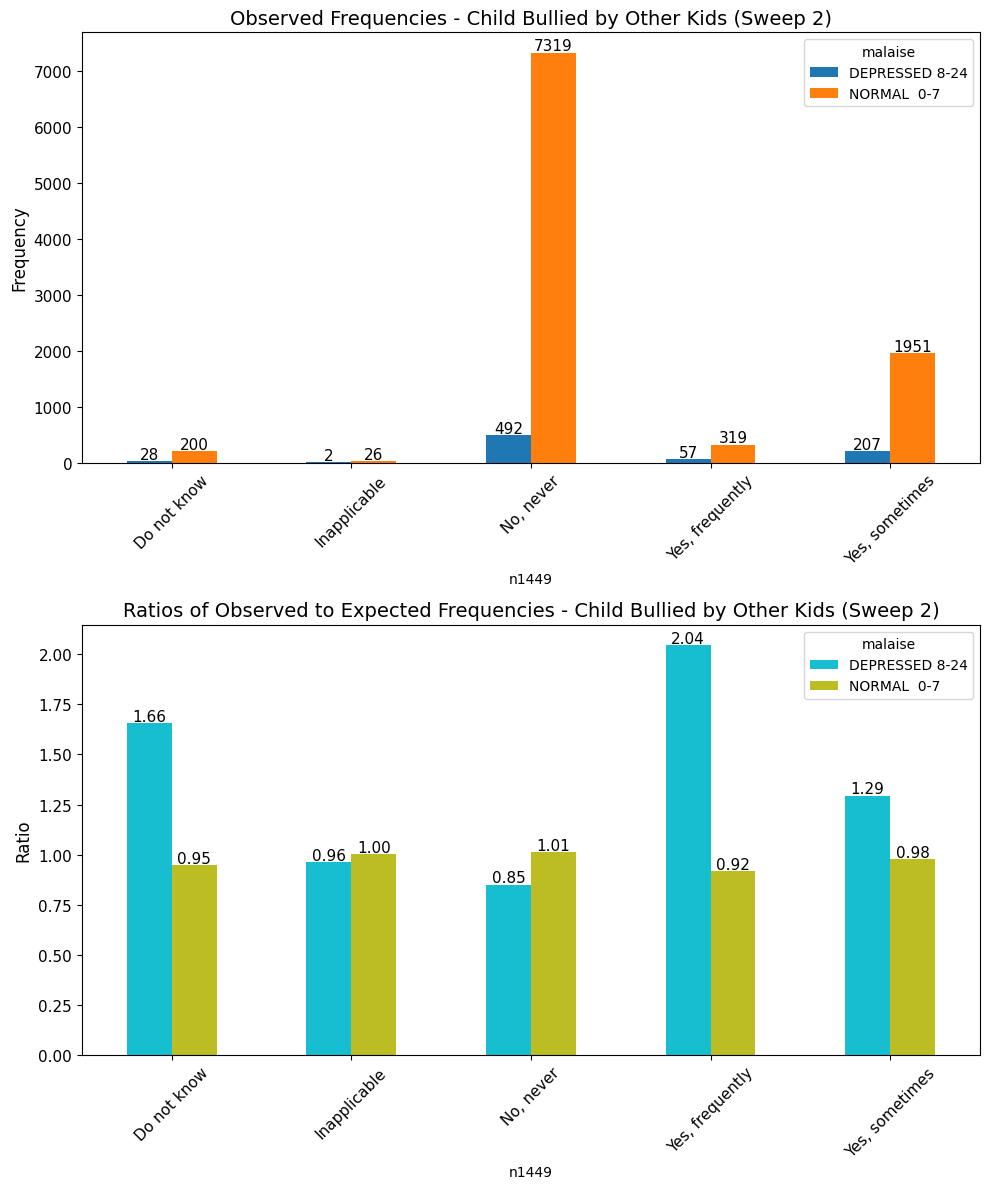

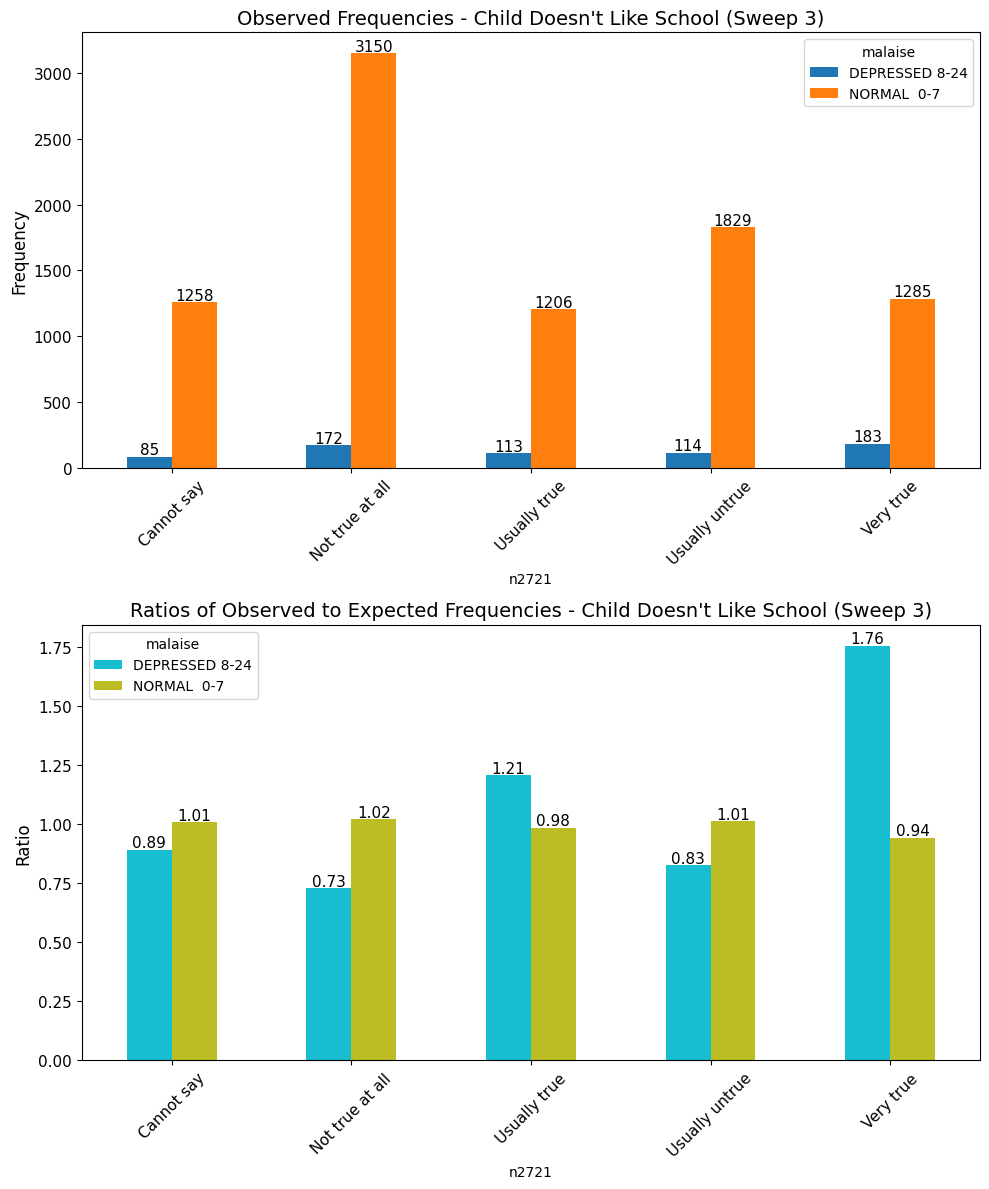

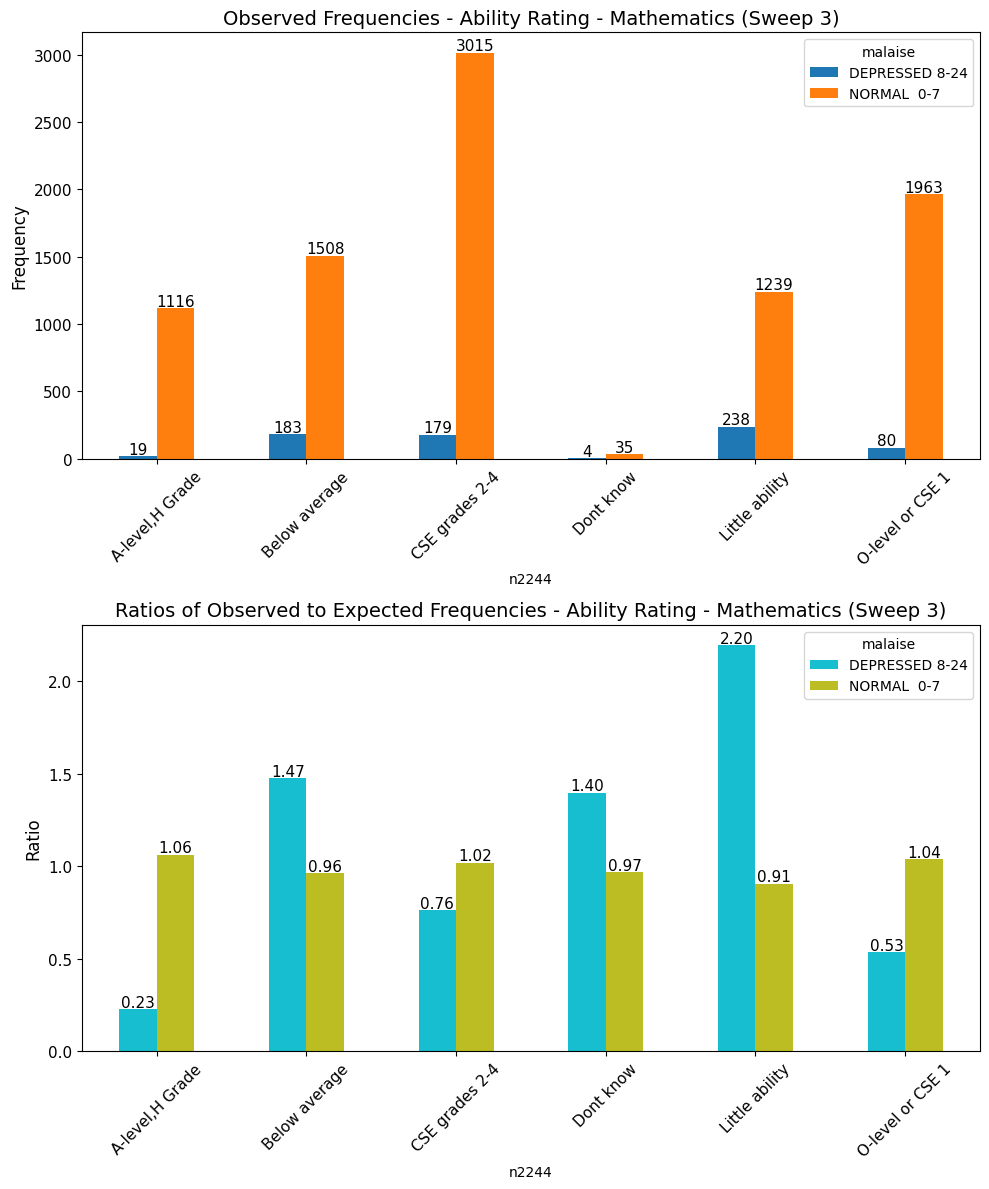

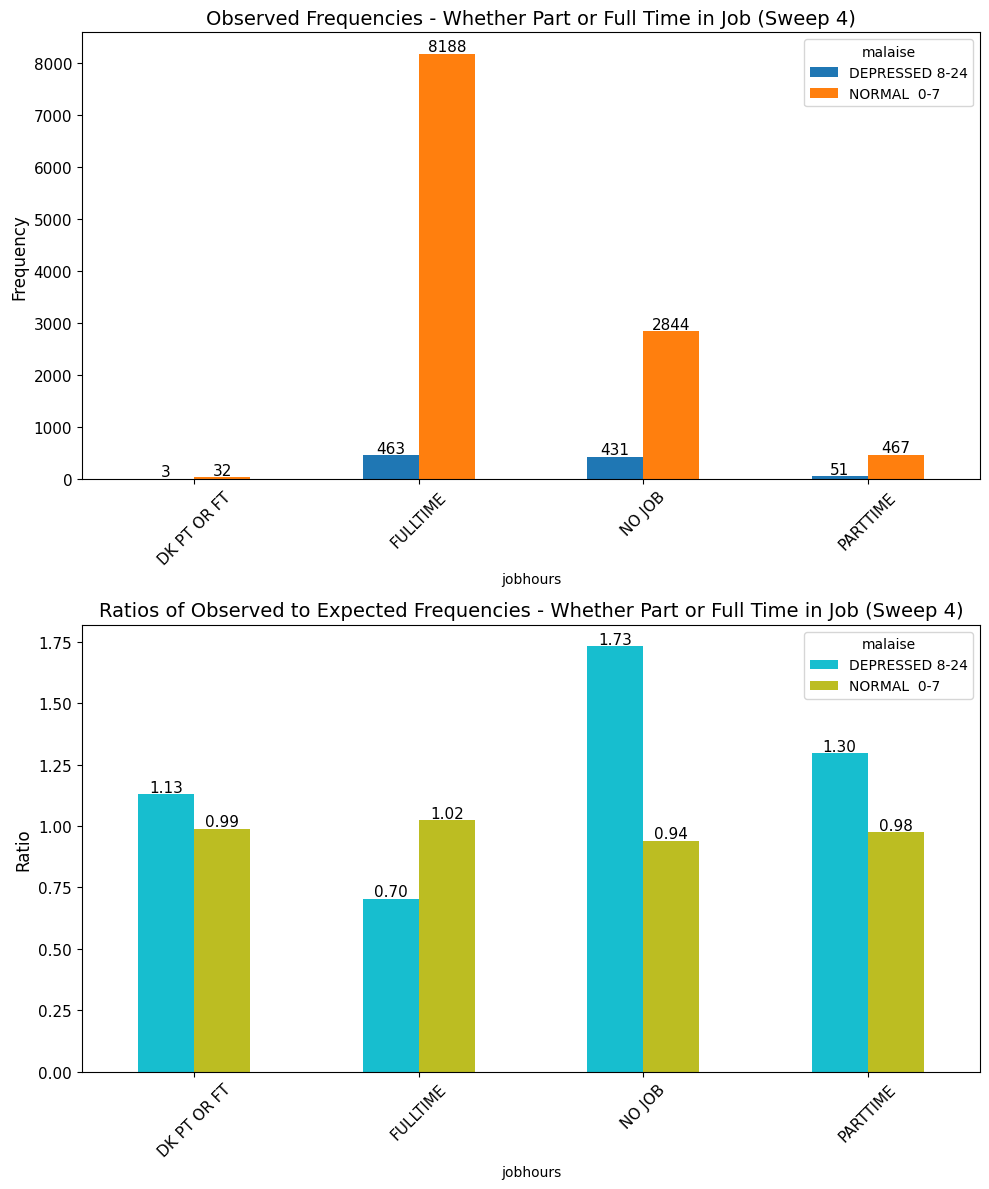

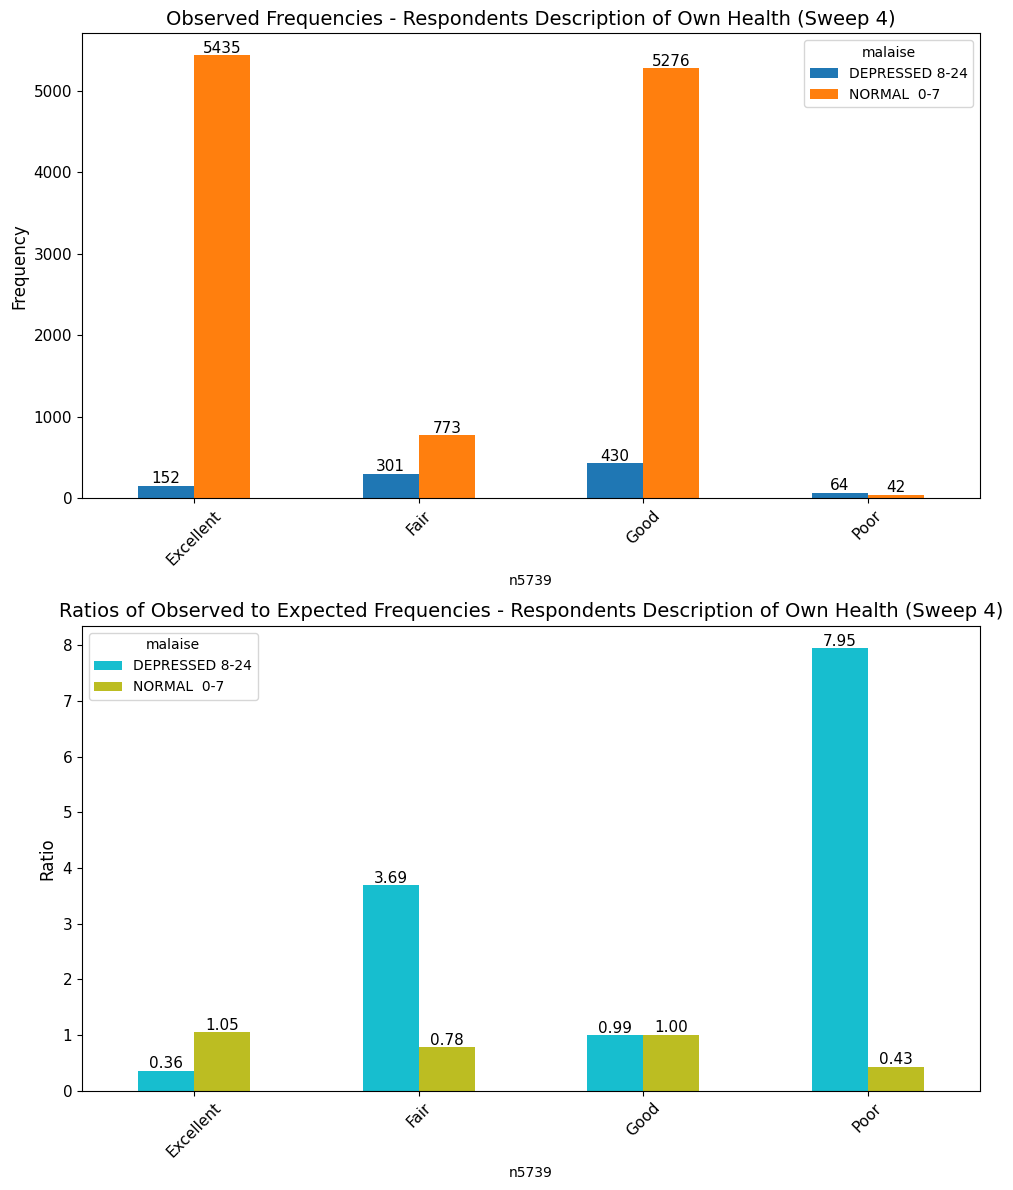

In [ ]:
#performs chi-squared test for specified variable
def perform_chi_squared(variable):
  contingency_table = pd.crosstab(all_sweeps[variable], all_sweeps['malaise'])
  chi2, p, dof, expected = chi2_contingency(contingency_table)
  return contingency_table, chi2, p, dof, expected

#plots the significance frequiencies of selected variables
def plot_frequencies(table, expected, title, ax):
  observed_frequencies = table
  expected_frequencies = pd.DataFrame(expected, columns=table.columns, index=table.index)

  observed_frequencies.plot(kind='bar', ax=ax[0], color=['#1f77b4', '#ff7f0e'])
  ax[0].set_title(f'Observed Frequencies - {title}', fontsize=14)
  ax[0].set_ylabel('Frequency', fontsize=12)
  ax[0].tick_params(axis='x', rotation=45, labelsize=11)
  ax[0].tick_params(axis='y', labelsize=11)
  add_values_on_bars(ax[0])

  ratios = observed_frequencies / expected_frequencies
  ratios.plot(kind='bar', ax=ax[1], color=['#17becf', '#bcbd22'])
  ax[1].set_title(f'Ratios of Observed to Expected Frequencies - {title}', fontsize=14)
  ax[1].set_ylabel('Ratio', fontsize=12)
  ax[1].tick_params(axis='x', rotation=45, labelsize=11)
  ax[1].tick_params(axis='y', labelsize=11)
  add_ratio_values_on_bars(ax[1])

#add values on bars
def add_values_on_bars(ax, spacing=5):
  for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, spacing), textcoords='offset points', fontsize=11)

def add_ratio_values_on_bars(ax, spacing=5):
  for p in ax.patches:
    ratio_value = f"{p.get_height():.2f}"
    ax.annotate(ratio_value, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                va='center', xytext=(0, spacing), textcoords='offset points', fontsize=11)

variables = ['n315', 'n70', 'n876', 'n1449', 'n2721', 'n2244', 'jobhours', 'n5739']
titles = [
  'Family Difficulties - Financial (Sweep 1)',
  "Number of Work - Teacher's Rating (Sweep 1)",
  "Child's General Knowledge - Teacher’s Rating (Sweep 2)",
  'Child Bullied by Other Kids (Sweep 2)',
  "Child Doesn't Like School (Sweep 3)",
  'Ability Rating - Mathematics (Sweep 3)',
  'Whether Part or Full Time in Job (Sweep 4)',
  'Respondents Description of Own Health (Sweep 4)'
]

for var, title in zip(variables, titles):
  contingency_table, chi2, p, dof, expected = perform_chi_squared(var)
  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
  plot_frequencies(contingency_table, expected, title, ax)
  plt.tight_layout()
  plt.show()